<a href="https://colab.research.google.com/github/awitz23/master_thesis/blob/main/working_prototype_sicherheit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dependencies

In [1]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestClassifier


In [2]:
!pip install pm4py
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
import sys
import pm4py
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import random
# Pfad zu einem Ordner mit mehreren Dateien


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=98b4f4acede7e89e781272cc13316ff4cb08803458bf53343489f48d9baa49b5
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=16968 sha256=558c6266d7da29b7600ddb959fd1aa376816c4f2bd39495042aba3dce55221aa
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist
Mounted at /content/drive


In [3]:

import pandas as pd
import pm4py
data_path = r"/content/drive/MyDrive/BPI_Challenge_2017.xes.gz"

In [4]:

if __name__ == "__main__":
    log = pm4py.read_xes(data_path)

df = log

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [5]:
log1 = log

In [6]:
log=df

In [7]:
len(df)

1202267

In [8]:
#log= df[df['concept:name'].str.startswith('W_')]


#print(log)

#Neuer Versuch, teilweise angelehnt an https://github.com/fmannhardt/starter-predictive-process-monitoring

Predictive Process Monitoring - A Starter Package for Jupyter

#Exploration

In [ ]:
#wie oft kommen die Arbeitsschritte im Eventlog vor
event_count = log['concept:name'].value_counts()
event_count

In [ ]:
event_count

value_cases = "A_Create Application"
number_cases = event_count.loc[value_cases]


min_count = number_cases  # Der Mindestwert, wie oft ein Element vorkommen muss

events_smaller_cases = event_count.index[event_count <= min_count]

In [ ]:
(log['concept:name'].unique())

In [ ]:
names = (log['concept:name'].unique())

In [ ]:
#EXTREM WICHTIG: Filtere alle Arbeitsschritte die mit W_ anfangen heraus

# Verwende eine List Comprehension, um die Elemente zu filtern
filtered_elements = [element for element in names if element.startswith('O_')]

# 'filtered_elements' enthält alle Elemente aus 'my_array', die mit 'W_' beginnen
print((filtered_elements))

In [ ]:
log = log.loc[log["concept:name"].isin(filtered_elements)]

In [ ]:
#count unique Applications
print(log['case:concept:name'].nunique())

In [ ]:
#get unique variants (--> variants = similar traces)
len(pm4py.get_variants_as_tuples(log))

In [ ]:
variants = pm4py.get_variants(log)

In [ ]:
# how does the process start
pm4py.get_start_activities(log_filtered)


In [ ]:
# how does the process end
pm4py.get_end_activities(log_filtered)

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
#remove all "unnecessary" events
log_filtered = pm4py.filter_event_attribute_values(log,
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = events_smaller_cases,
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = True)     # remove matching events

In [ ]:
#dfg for filtered log
dfg, start_activities, end_activities = pm4py.discover_dfg(log_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

In [ ]:
pm4py.get_event_attributes(log)

In [ ]:
pm4py.get_event_attribute_values(log, 'NumberOfTerms')

#Preprocessing und Bucketing (prefix bucketing)

In [173]:
log["start"]=pd.to_datetime(log['time:timestamp'])
log['start'] = log.groupby('case:concept:name')['start'].transform('min')
log['Time_Passed'] = log['time:timestamp'] - log['start']
log['Time_Passed_seconds'] = log['Time_Passed'].dt.total_seconds()

In [174]:
log.drop(log[log["concept:name"] == "W_Call after offers"].index, inplace=True)
log.drop(log[log["concept:name"] == "O_Accepted"].index, inplace=True)


Get Data to predict

In [175]:
log['Time_Passed_seconds']

0                0.000
1                0.048
2                0.470
3               81.088
4               81.099
              ...     
1202256     164967.237
1202257     164967.249
1202260     164967.258
1202264    1340007.898
1202265    1340007.923
Name: Time_Passed_seconds, Length: 991248, dtype: float64

In [176]:
len(log)

991248

In [177]:
#Teil für EINE ID
#list_all_id = log['case:concept:name'].tolist()
#print(list_all_id[:60])
#set_id = set(list_all_id)
#pred_id = random.sample(set_id,30)
#print(pred_id)

#pred_id = ''.join(map(str, pred_id))
#log = log.drop(log.loc[log['case:concept:name']==pred_id].index, inplace=False)
#pred_id_df = df.loc[df['case:concept:name']==pred_id]

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

#Teil für viele IDs

list_all_id = log['case:concept:name'].tolist()
#print(list_all_id[:60])
set_id = set(list_all_id)
pred_id_list = random.sample(set_id,30)
print(pred_id_list)

#pred_id = ''.join(map(str, pred_id))
log = log.drop(log.loc[log['case:concept:name'].isin(pred_id_list)].index, inplace=False)
pred_id_df = df.loc[df['case:concept:name'].isin(pred_id_list)]

from random import randrange
r = random.randint(19,20)
print(r)

from pm4py.objects.log.obj import EventLog, Trace
# generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
pred_id_df_prefixes_Accepted = pm4py.filter_prefixes(pred_id_df, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
pred_id_df_prefixes_Denied = pm4py.filter_prefixes(pred_id_df, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
pred_id_df_prefixes_Cancelled = pm4py.filter_prefixes(pred_id_df, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

pred_id_df_prefixes_Accepted["label"] = "accepted"
pred_id_df_prefixes_Cancelled["label"] = "not"
pred_id_df_prefixes_Denied["label"] = "not"

#generate df of log prefixes with length = value in length
trimmed_pred_id_df_Accepted = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Accepted, length=r, case_id_key='case:concept:name')
trimmed_pred_id_df_Denied = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Denied, length=r, case_id_key='case:concept:name')
trimmed_pred_id_df_Cancelled = pm4py.get_prefixes_from_log(pred_id_df_prefixes_Cancelled, length=r, case_id_key='case:concept:name')

pred_id_df_labeled_prefixes= pd.concat([trimmed_pred_id_df_Accepted, trimmed_pred_id_df_Denied, trimmed_pred_id_df_Cancelled], axis=0)

#pred_id_df_labeled_prefixes=pred_id_df_labeled_prefixes.drop('org:resource', axis=1)

gefiltertes_df = df[df["case:concept:name"]=="Application_1950726563"]

# Das gefilterte DataFrame anzeigen
print(gefiltertes_df)


Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


['Application_134147383', 'Application_1854482075', 'Application_532424186', 'Application_1591194403', 'Application_600946581', 'Application_778156059', 'Application_860729268', 'Application_474877479', 'Application_1522738855', 'Application_276445174', 'Application_347752818', 'Application_1322558151', 'Application_223278638', 'Application_952740547', 'Application_180427873', 'Application_547725647', 'Application_1778266019', 'Application_1581849799', 'Application_1593275377', 'Application_2115815413', 'Application_1295276940', 'Application_1001858108', 'Application_735610980', 'Application_1057803878', 'Application_1047460576', 'Application_892709259', 'Application_1470473934', 'Application_1263642271', 'Application_515224882', 'Application_756770333']
20
             Action org:resource              concept:name  EventOrigin  \
929196      Created       User_1      A_Create Application  Application   
929197  statechange       User_1               A_Submitted  Application   
929198 

In [178]:
pred_id_df_labeled_prefixes

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,Selected,CreditScore,OfferedAmount,OfferID,start,Time_Passed,Time_Passed_seconds,@@index_in_trace,@@temp_column,label
100980,Created,User_1,A_Create Application,Application,Application_1295276940,complete,2016-02-03 20:49:41.850000+00:00,Home improvement,New credit,Application_1295276940,...,NaN,NaN,NaN,NaN,2016-02-03 20:49:41.850000+00:00,0 days 00:00:00,0.000,0,38.0,accepted
100981,statechange,User_1,A_Submitted,Application,ApplState_1190241898,complete,2016-02-03 20:49:41.884000+00:00,Home improvement,New credit,Application_1295276940,...,NaN,NaN,NaN,NaN,2016-02-03 20:49:41.850000+00:00,0 days 00:00:00.034000,0.034,1,38.0,accepted
100982,Created,User_1,W_Handle leads,Workflow,Workitem_746788205,schedule,2016-02-03 20:49:42.117000+00:00,Home improvement,New credit,Application_1295276940,...,NaN,NaN,NaN,NaN,2016-02-03 20:49:41.850000+00:00,0 days 00:00:00.267000,0.267,2,38.0,accepted
100983,Deleted,User_1,W_Handle leads,Workflow,Workitem_2010354994,withdraw,2016-02-03 20:51:20.921000+00:00,Home improvement,New credit,Application_1295276940,...,NaN,NaN,NaN,NaN,2016-02-03 20:49:41.850000+00:00,0 days 00:01:39.071000,99.071,3,38.0,accepted
100984,Created,User_1,W_Complete application,Workflow,Workitem_200563221,schedule,2016-02-03 20:51:20.930000+00:00,Home improvement,New credit,Application_1295276940,...,NaN,NaN,NaN,NaN,2016-02-03 20:49:41.850000+00:00,0 days 00:01:39.080000,99.080,4,38.0,accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067205,Created,User_67,O_Create Offer,Offer,Offer_960507317,complete,2016-11-17 13:05:03.306000+00:00,Existing loan takeover,New credit,Application_515224882,...,False,0.0,15000.0,NaN,2016-11-17 12:49:05.669000+00:00,0 days 00:15:57.637000,957.637,5,10.0,not
1067206,statechange,User_67,O_Created,Offer,OfferState_463617637,complete,2016-11-17 13:05:04.072000+00:00,Existing loan takeover,New credit,Application_515224882,...,NaN,NaN,NaN,Offer_960507317,2016-11-17 12:49:05.669000+00:00,0 days 00:15:58.403000,958.403,6,10.0,not
1067207,statechange,User_67,O_Sent (mail and online),Offer,OfferState_76073117,complete,2016-11-17 13:20:47.335000+00:00,Existing loan takeover,New credit,Application_515224882,...,NaN,NaN,NaN,Offer_960507317,2016-11-17 12:49:05.669000+00:00,0 days 00:31:41.666000,1901.666,7,10.0,not
1067208,Deleted,User_67,W_Complete application,Workflow,Workitem_835023275,complete,2016-11-17 13:20:47.348000+00:00,Existing loan takeover,New credit,Application_515224882,...,NaN,NaN,NaN,NaN,2016-11-17 12:49:05.669000+00:00,0 days 00:31:41.679000,1901.679,8,10.0,not


In [179]:
#log.head(45)

In [180]:
#log.drop(columns=["lifecycle:transition","FirstWithdrawalAmount","NumberOfTerms","Accepted","MonthlyCost","Selected","CreditScore","OfferedAmount","OfferID"], inplace=True)


In [181]:
#log.info()

Prefixes

prefix buckets

In [182]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending

  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]
  #filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
  #filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
  #filtered_df['case:concept:name'] = filtered_df['new_id'] #nur wichtig für single Bucketing versuch !
  #filtered_df = filtered_df.drop(["new_id","NeueSpalte"],axis=1) #nur wichtig für single Bucketing versuch !
  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20
21


In [183]:
str_r = str(r)

desired_element = None

#look for bucket with correct amount of prefixes
for key in d.keys():
    if key.endswith(str_r):
        desired_element = d[key]
        break


In [184]:
def label_first_two_rows(id_group):

    if all(id_group.head(2)['org:resource'] == 'User_1'):
        print(id_group.head(2)['org:resource'])
        return 'Label_1'
    else:
        print(id_group.head(2)['org:resource'])
        return 'Label_2'

# Group the DataFrame by 'ID' and apply the labeling function
labels = desired_element.groupby('case:concept:name').apply(label_first_two_rows)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1199764    User_37
Name: org:resource, dtype: object
1026878    User_65
1026879    User_65
Name: org:resource, dtype: object
876582    User_1
876583    User_1
Name: org:resource, dtype: object
491942    User_1
491943    User_1
Name: org:resource, dtype: object
653012    User_1
653013    User_1
Name: org:resource, dtype: object
1182020    User_1
1182021    User_1
Name: org:resource, dtype: object
663282    User_38
663283    User_38
Name: org:resource, dtype: object
408103    User_83
408104    User_83
Name: org:resource, dtype: object
302068    User_1
302069    User_1
Name: org:resource, dtype: object
323069    User_1
323070    User_1
Name: org:resource, dtype: object
343869    User_36
343870    User_36
Name: org:resource, dtype: object
644145    User_1
644146    User_1
Name: org:resource, dtype: object
643207    User_1
643208    User_1
Name: org:resource, dtype: object
21872    User_1
21873    User_1
Name: org:resource, 

In [185]:
desired_element['Label'] = desired_element['org:resource'].map(labels)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [186]:
desired_element = desired_element.merge(labels.rename('New_Data'), left_on='case:concept:name', right_index=True, how='left')


In [187]:
desired_element["Online_Application"] = desired_element["New_Data"].replace({'Label_1': 1, 'Label_2': 0})


In [188]:
desired_element['Online_Application'].value_counts()

1    267600
0    136100
Name: Online_Application, dtype: int64

In [190]:
desired_element

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,OfferID,start,Time_Passed,Time_Passed_seconds,@@index_in_trace,@@temp_column,label,Label,New_Data,Online_Application
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00,0.000,0,31.0,accepted,NaN,Label_1,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.048000,0.048,1,31.0,accepted,NaN,Label_1,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.470000,0.470,2,31.0,accepted,NaN,Label_1,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.088000,81.088,3,31.0,accepted,NaN,Label_1,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.099000,81.099,4,31.0,accepted,NaN,Label_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201186,statechange,User_96,O_Created,Offer,OfferState_56752539,complete,2017-01-02 15:18:30.077000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:44:48.259000,189888.259,15,60.0,not,NaN,Label_1,1
1201187,statechange,User_96,O_Sent (mail and online),Offer,OfferState_975688523,complete,2017-01-02 15:19:44.585000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.767000,189962.767,16,60.0,not,NaN,Label_1,1
1201188,Deleted,User_96,W_Complete application,Workflow,Workitem_832468832,complete,2017-01-02 15:19:44.599000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.781000,189962.781,17,60.0,not,NaN,Label_1,1
1201191,statechange,User_96,A_Complete,Application,ApplState_1084169688,complete,2017-01-02 15:19:44.612000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.794000,189962.794,18,60.0,not,NaN,Label_1,1


#Encoding (aggregate encoding)

In [191]:
desired_element

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,OfferID,start,Time_Passed,Time_Passed_seconds,@@index_in_trace,@@temp_column,label,Label,New_Data,Online_Application
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00,0.000,0,31.0,accepted,NaN,Label_1,1
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.048000,0.048,1,31.0,accepted,NaN,Label_1,1
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:00:00.470000,0.470,2,31.0,accepted,NaN,Label_1,1
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.088000,81.088,3,31.0,accepted,NaN,Label_1,1
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,2016-01-01 09:51:15.304000+00:00,0 days 00:01:21.099000,81.099,4,31.0,accepted,NaN,Label_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201186,statechange,User_96,O_Created,Offer,OfferState_56752539,complete,2017-01-02 15:18:30.077000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:44:48.259000,189888.259,15,60.0,not,NaN,Label_1,1
1201187,statechange,User_96,O_Sent (mail and online),Offer,OfferState_975688523,complete,2017-01-02 15:19:44.585000+00:00,Home improvement,New credit,Application_1722592475,...,Offer_1075595033,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.767000,189962.767,16,60.0,not,NaN,Label_1,1
1201188,Deleted,User_96,W_Complete application,Workflow,Workitem_832468832,complete,2017-01-02 15:19:44.599000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.781000,189962.781,17,60.0,not,NaN,Label_1,1
1201191,statechange,User_96,A_Complete,Application,ApplState_1084169688,complete,2017-01-02 15:19:44.612000+00:00,Home improvement,New credit,Application_1722592475,...,NaN,2016-12-31 10:33:41.818000+00:00,2 days 04:46:02.794000,189962.794,18,60.0,not,NaN,Label_1,1


In [192]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name',
           #'org:resource',
           #'EventOrigin'
           #,"Time_Passed_seconds"
           ]
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(desired_element, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)


# Ergebnisse anzeigen
#for spalte, pivot_table in zip(spalten, pivot_tables):
 #   if ergebnis_df.empty:
  #      ergebnis_df = pivot_table
   # else:
    #    ergebnis_df = ergebnis_df.join(pivot_table, on=spalte, rsuffix=f'_{spalte}')

    #print(f"Pivot-Tabelle für Spalte {spalte}:")
    #print(pivot_table)
    #print("\n")

#print(len(pivot_tables[1]))

In [193]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], #pivot_tables[1],
                         #pivot_tables[2]
                         ])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)

# Ergebnis anzeigen
#print(df_dynamic_event_cat)

# Ergebnis anzeigen
#print(combined_df)

In [194]:
#static trace cat
work_around = pd.DataFrame()
work_around = desired_element[['case:concept:name',
                               "case:LoanGoal",
                               'case:ApplicationType',
                               'case:RequestedAmount',
                               "label",
                               #"Time_Passed_seconds",
                               "Online_Application"
                               ]]
#work_around['Time_Passed_seconds'] = work_around.groupby('case:concept:name')['Time_Passed_seconds'].transform('max') #umweg um "Time_Passed_seconds" zu verarbeiten

desired_element_time = desired_element.groupby('case:concept:name')['Time_Passed_seconds'].max().reset_index()

# Merge the aggregated dfA_max with dfB based on the 'key' column
work_around = work_around.merge(desired_element_time, on='case:concept:name', how='left')


work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")




In [195]:
work_around_feature_table = pd.get_dummies(work_around)
#work_around_feature_table

In [196]:
print(work_around)

                                 case:LoanGoal case:ApplicationType  \
case:concept:name                                                     
Application_652823628   Existing loan takeover           New credit   
Application_428409768         Home improvement           New credit   
Application_1746793196                     Car           New credit   
Application_619403287                      Car           New credit   
Application_1529124572  Other, see explanation           New credit   
...                                        ...                  ...   
Application_1855944075        Home improvement           New credit   
Application_634831049                      Car           New credit   
Application_688832703   Other, see explanation           New credit   
Application_380535005         Home improvement           New credit   
Application_1722592475        Home improvement           New credit   

                        case:RequestedAmount     label  Online_Application  

In [197]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [198]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

# Merge the aggregated dfA_max with dfB based on the 'key' column
#df_all_infos = df_all_infos.merge(desired_element_time, on='case:concept:name', how='left')


In [199]:
df_all_infos

,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),A_Complete,...,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit,label_accepted,label_not
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_428409768,1.0,1.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_1746793196,1.0,1.0,3.0,12.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_619403287,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Application_1529124572,1.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_1855944075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Application_634831049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
Application_688832703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [200]:
work_around_feature_table.head(5)

,case:RequestedAmount,Online_Application,Time_Passed_seconds,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit,label_accepted,label_not
case:concept:name,,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,1,1121105.659,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
Application_428409768,15000.0,1,1028264.172,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
Application_1746793196,5000.0,1,276261.981,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
Application_619403287,15000.0,1,935213.547,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
Application_1529124572,5000.0,1,2145905.365,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0


In [201]:
#desired_element_time = desired_element.groupby('case:concept:name')['Time_Passed_seconds'].max().reset_index()

# Merge the aggregated dfA_max with dfB based on the 'key' column
#df_all_infos = df_all_infos.merge(desired_element_time, on='case:concept:name', how='left')


In [202]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos_labeled = df_all_infos
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

                        A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                           
Application_652823628                    1.0          1.0             2.0   
Application_428409768                    1.0          1.0             2.0   
Application_1746793196                   1.0          1.0             3.0   
Application_619403287                    1.0          1.0             2.0   
Application_1529124572                   1.0          1.0             2.0   
...                                      ...          ...             ...   
Application_1855944075                   1.0          1.0             3.0   
Application_634831049                    1.0          1.0             3.0   
Application_688832703                    1.0          0.0             0.0   
Application_380535005                    1.0          1.0             2.0   
Application_1722592475                   1.0          1.0             2.0   

In [203]:
df_all_infos_labeled.to_csv("df_all_infos_labeled.csv")

#zweites Encoding (index based)

In [ ]:
desired_element

In [ ]:
list(desired_element_index)


In [ ]:
desired_element_index = desired_element.drop(['Action',
                                              'org:resource',

                                              'EventOrigin',
                                              'EventID',
                                              'lifecycle:transition',
                                              'time:timestamp',
                                              'FirstWithdrawalAmount',
                                              'NumberOfTerms',
                                              'Accepted',
                                              'MonthlyCost',
                                              'Selected',
                                              'CreditScore',
                                              'OfferedAmount',
                                              'OfferID',
                                              'start',
                                              'Time_Passed',
                                              '@@temp_column',
                                              'Label',
                                              'New_Data',], axis=1)


In [ ]:
desired_element_index

In [ ]:
df = pd.DataFrame(desired_element_index)

# Create a sequence column based on the Event
df['Sequence'] = df.groupby('case:concept:name').cumcount() + 1

# Pivot the DataFrame to one-hot encode the events
pivot_df = df.pivot(index='case:concept:name', columns='Sequence', values='concept:name').add_prefix('Event_')

# Reset the index and fill NaN values with a placeholder (e.g., 'No_Event')
pivot_df = pivot_df.reset_index().fillna('No_Event')

# Join the original data with the one-hot encoding
final_df = df[['case:concept:name', 'case:LoanGoal', 'case:ApplicationType',  'case:RequestedAmount', 'Time_Passed_seconds',  'label',  'Online_Application']].merge(pivot_df, left_on='case:concept:name', right_on='case:concept:name')





# Rename the columns as needed
final_df.columns = [col if col != 'case:concept:name' else 'case:concept:name' for col in final_df.columns]

# Display the final DataFrame
print(final_df)

In [ ]:
#max_time_rows = final_df.loc[final_df.groupby('case:concept:name')['Time_Passed_seconds'].idxmax()]

# Reset the index of the resulting DataFrame if needed
#max_time_rows.reset_index(drop=True, inplace=True)

##glaube das ist alles redundant

In [ ]:
# Create a new column with the maximum 'Time_Passed_seconds' for each group
final_df['max_Time_Passed_seconds'] = final_df.groupby('case:concept:name')['Time_Passed_seconds'].transform('max')

# Filter the DataFrame to keep only rows where 'Time_Passed_seconds' equals the maximum value
max_time_rows = final_df[final_df['Time_Passed_seconds'] == final_df['max_Time_Passed_seconds']]

# Drop the temporary 'max_Time_Passed_seconds' column if needed
max_time_rows = max_time_rows.drop(columns='max_Time_Passed_seconds')

# Display the resulting DataFrame
print(max_time_rows)

In [ ]:
max_time_rows_events = max_time_rows.drop(['case:LoanGoal', 'case:ApplicationType',  'case:RequestedAmount', 'Time_Passed_seconds',  'label',  'Online_Application'], axis=1)
max_time_rows_events.set_index("case:concept:name", inplace=True)



max_time_rows_feature_table = pd.get_dummies(max_time_rows_events)

In [ ]:
start_column_index = 7
end_column_index = len(max_time_rows.columns)

# Drop columns from the specified range
max_time_rows_static = max_time_rows.drop(max_time_rows.columns[start_column_index:end_column_index], axis=1)
max_time_rows_static.set_index("case:concept:name", inplace=True)

max_time_rows_static_one_hot = max_time_rows_static.drop(["case:RequestedAmount",	"Time_Passed_seconds", "Online_Application", "label"], axis=1)
max_time_rows_static_one_hot

,case:LoanGoal,case:ApplicationType
case:concept:name,,
Application_652823628,Existing loan takeover,New credit
Application_428409768,Home improvement,New credit
Application_1746793196,Car,New credit
Application_619403287,Car,New credit
Application_1529124572,"Other, see explanation",New credit
...,...,...
Application_434636699,Car,New credit
Application_188935499,Existing loan takeover,New credit
Application_1986755838,Car,New credit


In [ ]:
max_time_rows_static_one_hot = pd.get_dummies(max_time_rows_static_one_hot)

In [ ]:
numerical_cols = ["case:RequestedAmount",	"Time_Passed_seconds", "Online_Application"]
max_time_rows_static_numerical = max_time_rows_static[numerical_cols]

In [ ]:
max_time_rows_static = max_time_rows_static_numerical.merge(max_time_rows_static_one_hot, how='left', left_index=True, right_index=True)


In [ ]:
max_time_rows_static

,case:RequestedAmount,Time_Passed_seconds,Online_Application,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,430553.168,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
Application_428409768,15000.0,86787.911,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
Application_1746793196,5000.0,276065.219,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_619403287,15000.0,849158.751,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_1529124572,5000.0,584904.293,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_434636699,15000.0,417079.921,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Application_188935499,21000.0,82120.368,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
Application_1986755838,16500.0,579850.146,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Labels extrahieren

list_1 = max_time_rows['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)

In [ ]:
index_encoding_all_infos = max_time_rows_static.merge(max_time_rows_feature_table, how='left', left_index=True, right_index=True)


#index_encoding_all_infos = pd.concat([max_time_rows_static,max_time_rows_feature_table])


In [ ]:
index_encoding_all_infos

,case:RequestedAmount,Time_Passed_seconds,Online_Application,case:LoanGoal_Boat,case:LoanGoal_Business goal,case:LoanGoal_Car,case:LoanGoal_Caravan / Camper,case:LoanGoal_Debt restructuring,case:LoanGoal_Existing loan takeover,case:LoanGoal_Extra spending limit,...,Event_19_O_Returned,Event_19_O_Sent (mail and online),Event_19_O_Sent (online only),Event_19_W_Assess potential fraud,Event_19_W_Call after offers,Event_19_W_Call incomplete files,Event_19_W_Complete application,Event_19_W_Handle leads,Event_19_W_Shortened completion,Event_19_W_Validate application
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,20000.0,430553.168,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Application_428409768,15000.0,86787.911,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Application_1746793196,5000.0,276065.219,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Application_619403287,15000.0,849158.751,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Application_1529124572,5000.0,584904.293,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Application_434636699,15000.0,417079.921,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Application_188935499,21000.0,82120.368,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Application_1986755838,16500.0,579850.146,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#Data Scaling (index encoding)

In [ ]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(index_encoding_all_infos)

scaler_y = FunctionTransformer() # for binary values scaling does not make sense at all but we keep it for symetry and apply the "NoOp" scaler
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target_scaled, test_size=0.33, random_state=42)

NameError: ignored

In [ ]:
X_train = pd.DataFrame(X_train, columns = index_encoding_all_infos.columns)


In [ ]:
X_train.head(5)

#Data Scaling

In [204]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(df_all_infos)

scaler_y = FunctionTransformer()
target_scaled = scaler_y.fit_transform(list_3.reshape(-1, 1))

In [205]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target_scaled, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [206]:
target_scaled

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [207]:
X_train = pd.DataFrame(X_train, columns = df_all_infos.columns)
X_test= pd.DataFrame(X_test, columns = df_all_infos.columns)


#X_train = X_train.drop(["W_Call after offers"],axis=1)
#X_test = X_test.drop(["W_Call after offers"],axis=1)

In [210]:
X_train.head()

,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),A_Complete,...,case:LoanGoal_Extra spending limit,case:LoanGoal_Home improvement,case:LoanGoal_Motorcycle,case:LoanGoal_Not speficied,"case:LoanGoal_Other, see explanation",case:LoanGoal_Remaining debt home,case:LoanGoal_Tax payments,case:LoanGoal_Unknown,case:ApplicationType_Limit raise,case:ApplicationType_New credit
0,0.0,1.0,0.111111,0.222222,1.0,1.0,0.333333,0.333333,0.4,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.111111,0.388889,1.0,1.0,0.166667,0.166667,0.2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.111111,0.166667,1.0,1.0,0.333333,0.333333,0.4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.000000,0.777778,1.0,1.0,0.166667,0.166667,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.000000,0.166667,1.0,1.0,0.166667,0.166667,0.2,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#Punkt: Predict Data erzeugen

In [142]:
#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['case:concept:name'] == "Application_652823628"]

#New_Data = d['data_labeled_prefixes18'][d['data_labeled_prefixes18']['label'] == "accepted"]

# Ergebnis anzeigen
#print(New_Data)

#New data entspricht dem Teil des Dataframes für einen Trace ! So muss das noch gecodet werden

In [143]:
#d['data_labeled_prefixes18'].head(5)

In [144]:
spalten = ['concept:name', 'org:resource', 'EventOrigin']
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables_predict_point = []
for spalte in spalten:
    pivot_table_predict_point = pd.pivot_table(pred_id_df_labeled_prefixes, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables_predict_point.append(pivot_table_predict_point)

combined_df_predict_point = pd.concat([pivot_tables_predict_point[0], pivot_tables_predict_point[1], pivot_tables_predict_point[2]])

df_dynamic_event_cat = combined_df_predict_point.groupby(combined_df_predict_point.index, sort=False).agg('first',)

work_around_predict_point = pd.DataFrame()
work_around_predict_point = pred_id_df_labeled_prefixes[['case:concept:name',"case:LoanGoal",'case:ApplicationType','case:RequestedAmount',"label"]]
work_around_predict_point = work_around_predict_point.drop_duplicates()
work_around_predict_point = work_around_predict_point.set_index("case:concept:name")

work_around_feature_table_predict_point = pd.get_dummies(work_around_predict_point)

df_all_infos_predict_point = pd.concat([df_dynamic_event_cat,work_around_feature_table_predict_point])

df_all_infos_predict_point = df_all_infos_predict_point.groupby(df_all_infos_predict_point.index, sort=False).agg('first',)
#df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos_predict_point))

                        A_Create Application  A_Submitted  W_Handle leads  \
case:concept:name                                                           
Application_138867953                    1.0          1.0             2.0   
Application_1072131214                   1.0          1.0             2.0   
Application_1401417715                   1.0          1.0             2.0   
Application_2037345411                   1.0          0.0             0.0   
Application_1373703121                   1.0          0.0             0.0   
Application_177188777                    1.0          1.0             2.0   
Application_1278220738                   1.0          1.0             2.0   
Application_1814042936                   1.0          1.0             2.0   
Application_119587961                    1.0          1.0             2.0   
Application_635712336                    1.0          1.0             3.0   
Application_1075501196                   1.0          0.0             0.0   

In [145]:
new_df_data = pd.DataFrame(0, columns=X_train.columns, index=df_all_infos_predict_point.index)

# Aktualisieren Sie die Spalten aus df_data in new_df_data
for column in new_df_data.columns:
  if column in df_all_infos_predict_point.columns:
    new_df_data[column] = df_all_infos_predict_point[column]

# Ergebnis anzeigen
#print(new_df_data)



In [146]:
pivot_tables_predict_point[0]

concept:name,A_Create Application,A_Submitted,W_Handle leads,W_Complete application,A_Concept,A_Accepted,O_Create Offer,O_Created,O_Sent (mail and online),A_Complete,W_Validate application,A_Validating,O_Returned,O_Cancelled,W_Call incomplete files
case:concept:name,,,,,,,,,,,,,,,
Application_138867953,1,1,2,3,1,1,1,1,1,1,4,1,1,0,0
Application_1072131214,1,1,2,4,1,1,2,2,2,1,2,0,0,0,0
Application_1401417715,1,1,2,6,1,1,1,1,1,1,2,1,0,0,0
Application_2037345411,1,0,0,4,1,1,2,2,2,1,4,1,0,0,0
Application_1373703121,1,0,0,3,1,1,2,2,2,1,3,1,1,1,0
Application_177188777,1,1,2,6,1,1,1,1,1,1,2,1,0,0,0
Application_1278220738,1,1,2,2,1,1,1,1,1,1,4,1,1,0,1
Application_1814042936,1,1,2,4,1,1,1,1,1,1,3,1,1,0,0
Application_119587961,1,1,2,3,1,1,2,2,2,1,2,1,0,0,0


In [170]:
new_df_data["Time_Passed_seconds"]

case:concept:name
Application_138867953     0
Application_1072131214    0
Application_1401417715    0
Application_2037345411    0
Application_1373703121    0
Application_177188777     0
Application_1278220738    0
Application_1814042936    0
Application_119587961     0
Application_635712336     0
Application_1075501196    0
Application_22921733      0
Application_2029300358    0
Application_2015889423    0
Application_1481162623    0
Application_1958515425    0
Application_1894051107    0
Application_2126475285    0
Application_1351535871    0
Application_14401241      0
Application_821907135     0
Application_1675186195    0
Application_1732221433    0
Application_600773420     0
Application_312193292     0
Application_871295989     0
Application_731883220     0
Application_1550643436    0
Application_1299469760    0
Application_1296990203    0
Name: Time_Passed_seconds, dtype: int64

#Model

#LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(4,input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
history = model.fit(x=X_train,y=y_train,epochs=10,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/10
519/519 [==============================] - 11s 16ms/step - loss: 0.2439 - val_loss: 0.2332
Epoch 2/10
519/519 [==============================] - 10s 19ms/step - loss: 0.2350 - val_loss: 0.2313
Epoch 3/10
519/519 [==============================] - 9s 17ms/step - loss: 0.2333 - val_loss: 0.2298
Epoch 4/10
519/519 [==============================] - 9s 17ms/step - loss: 0.2319 - val_loss: 0.2285
Epoch 5/10
519/519 [==============================] - 10s 19ms/step - loss: 0.2309 - val_loss: 0.2276
Epoch 6/10
519/519 [==============================] - 9s 17ms/step - loss: 0.2301 - val_loss: 0.2270
Epoch 7/10
519/519 [==============================] - 10s 19ms/step - loss: 0.2296 - val_loss: 0.2267
Epoch 8/10
519/519 [==============================] - 8s 15ms/step - loss: 0.2293 - val_loss: 0.2265
Epoch 9/10
519/519 [==============================] - 10s 19ms/step - loss: 0.2291 - val_loss: 0.2264
Epoch 10/10
519/519 [==============================] - 11s 21ms/step - loss: 0.2290 - 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
from sklearn import metrics


In [ ]:
Y_p=(model.predict(X_train))
Y_t=(y_train.reshape(y_train.shape[0],1))
print((1-(metrics.mean_absolute_error(Y_t, Y_p)/Y_t.mean()))*100)

519/519 [==============================] - 3s 4ms/step
26.416939825660002


In [ ]:
print((1-(metrics.mean_absolute_error(Y_t, Y_p)/Y_t.mean()))*100)

26.416939825660002


In [ ]:
y_pred = model.predict(X_test)

# Convert predictions to binary values (e.g., 0 or 1) based on a threshold
# This step depends on your specific problem. For binary classification, you can use:
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(np.equal(y_test, y_pred_binary))

print("Accuracy:", accuracy)

173/173 [==============================] - 1s 4ms/step
Accuracy: 0.6314647377938517


#Random Forest

In [ ]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

In [ ]:
preds = rf.predict(X_test)


In [ ]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds,  labels = [1, 2])


In [ ]:
print(preds)

In [ ]:
predicted_class = rf.predict(new_df_data)
print(predicted_class)

#Gradient Boosting

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

In [149]:
clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=400).fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [150]:

print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7788032850997263
0.7534021586109808


In [151]:
predicted_y_pred = clf.predict(X_test)

In [152]:
len(y_test)

4262

In [153]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(predicted_y_pred, y_test).ravel()
print(tn, fp, fn, tp)

371 249 802 2840


In [154]:
confusion_matrix(predicted_y_pred, y_test, labels=[1, 0])

array([[2840,  802],
       [ 249,  371]])

In [155]:
predicted_class = clf.predict(new_df_data)
print(predicted_class)

[0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0]


In [156]:
unique, counts = np.unique(predicted_class, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 21]
 [ 1  9]]


#CART

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
predicted_y_pred = clf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(predicted_y_pred, y_test).ravel()
print(tn, fp, fn, tp)

14812 4030 3958 24439


#Benchmarking

In [ ]:
!pip install catboost

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
!pip install xgboost
from xgboost import XGBClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

GBC: 0.671647 (0.004141)


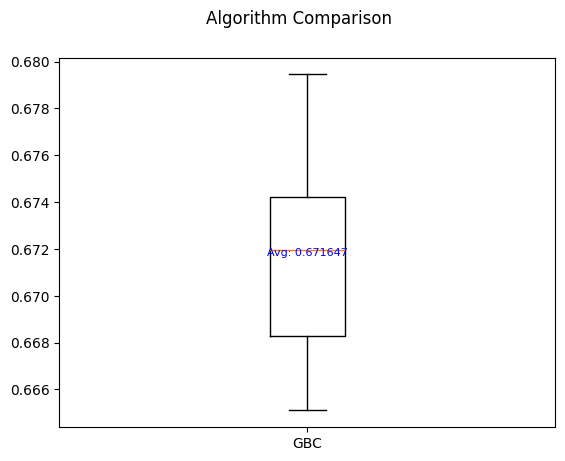

In [ ]:
X=data_scaled
Y=target_scaled

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(("XGB", XGBClassifier()))
#models.append(('CB', CatBoostClassifier(learning_rate=0.11, max_depth=12, n_estimators=80)))
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('GBC', GradientBoostingClassifier()))


#models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = model_selection.KFold(n_splits=10,shuffle=True, random_state=seed)
 cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

averages = [np.mean(result) for result in results]


for i, avg in enumerate(averages):
    ax.text(i + 1, avg, f'Avg: {avg:.6f}', ha='center', va='bottom', fontsize=8, color='blue')


plt.show()

In [ ]:
X=df_all_infos
Y=list_3

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('CB', CatBoostClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
 kfold = model_selection.KFold(n_splits=10,shuffle=True, random_state=seed)
 cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
#ax.set_xticklabels(names)
plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

averages = [np.mean(result) for result in results]


for i, avg in enumerate(averages):
    ax.text(i + 1, avg, f'Avg: {avg:.6f}', ha='center', va='bottom', fontsize=8, color='blue')


plt.show()

In [ ]:
durchschnitte=[]
for array in results:
    durchschnitt = sum(array) / len(array)
    durchschnitte.append(durchschnitt)

print("Durchschnitte der Arrays:", durchschnitte)

#Hyperparameter

In [ ]:
!pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.0 MB/s eta 0:00:00


In [ ]:


# Define search space for hyperparameters
param_space = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,],
    'max_depth': [1, 2,3,4, 5,6,7,8,9, 10],
    'n_estimators': [100, 200, 300, 350, 400, 450, 500]#, 750, 900, 1000]
}



# Define configuration for Bayesian optimizer
#opt_config = {
 #   "base_estimator": "GP",
  #  "initial_point_generator": Grid(
   #     border="exclude", use_full_layout=False
    #),
#}

# Create BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=GradientBoostingClassifier(),
    search_spaces=param_space,
    n_iter=20,
    cv=5,
    #n_jobs=-1,
    #random_state=42,
    #scoring=mean_recall_at_10_scorer,
    #optimizer_kwargs=opt_config,
    verbose=1,
    #return_train_scoreboolean=True
)



# Perform hyperparameter tuning using GroupKFold cross-validation
bayes_search.fit(X_val, y_val)

# Print best parameters and score
print("Best parameters found:", bayes_search.best_params_)
print("Best score found:", bayes_search.best_score_)

# Access the mean test scores for all cross-validation splits and parameter combinations
print(bayes_search.cv_results_['mean_test_score'])


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

Best parameters found: OrderedDict([('learning_rate', 0.06), ('max_depth', 2), ('n_estimators', 300)])
Best score found: 0.6674502712477396
[0.65551537 0.64990958 0.66690778 0.66202532 0.64104882 0.66528029
 0.65678119 0.63869801 0.66274864 0.65443038 0.64629295 0.66509946
 0.63761302 0.65840868 0.63652803 0.66274864 0.66672694 0.66274864
 0.66745027 0.65985533]


In [ ]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


n_features = df_all_infos.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, df_all_infos, list_3, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))

from skopt.plots import plot_convergence

plot_convergence(res_gp)

KeyboardInterrupt: ignored

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(0)

GB_opt = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        'learning_rate': (10e-6, 1.0, 'log-uniform'),
        'max_depth': Integer(0, 50, 'uniform'),
        'n_estimators' : (10, 1000, 'log-uniform'),
    },
    n_iter=10,
    cv=3
)

GB_opt.fit(X_train, y_train)
#GB_tuned_fcst = opt.best_estimator_.predict(X_test)
#r2_score(list(y_test), list(xgb_tuned_fcst))

NameError: ignored

In [ ]:
best_params = GB_opt.best_params_
best_score = GB_opt.best_score_

print("Optimal Hyperparameters:", best_params)
print("Best Score:", best_score)

Optimal Hyperparameters: OrderedDict([('learning_rate', 0.08730510770093697), ('max_depth', 4), ('n_estimators', 48)])
Best Score: 0.1318588311354092


In [ ]:
print("Best parameters found:", bayes_search.best_params_)
print("Best score found:", bayes_search.best_score_)

# Access the mean test scores for all cross-validation splits and parameter combinations
print(bayes_search.cv_results_['mean_test_score'])

Best parameters found: OrderedDict([('learning_rate', 0.01074866207647661), ('max_depth', 11), ('n_estimators', 146)])
Best score found: 0.658424652343602
[0.62090353 0.62705829 0.63310495 0.59558429 0.62873181 0.62495294
 0.61285989 0.62538467 0.63126888 0.6577766  0.62052583 0.62052583
 0.65621106 0.65842465 0.65469907]


In [ ]:
!pip install xgboost
from xgboost import XGBClassifier



In [ ]:

model_params = {
    'GB': {
        'model': GradientBoostingClassifier(),
        'params' : {
          'learning_rate': (0.01, 1.0, 'log-uniform'),
          'max_depth': (1, 30),
          'n_estimators': (1, 1000),
          'verbose': 1
        }
    },
    'Catboost': {
        'model': CatBoostClassifier(),
        'params' : {
          'learning_rate': (0.01, 1.0, 'log-uniform'),
          'max_depth': (1, 30),
          'n_estimators': (1, 1000)
        }
    },
    'xgb' : {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
          'max_depth': (1, 30),
          'n_estimators': (1, 1000)
        }
    }
}





In [ ]:
scores = []

for model_name, mp in model_params.items():
    # Convert the search space dictionary to a list of hyperparameter search spaces
    search_spaces = []
    for param_name, param_range in mp['params'].items():
        search_spaces.append(param_range)

    bayes_search = BayesSearchCV(estimator=mp['model'], search_spaces=search_spaces, cv=5, return_train_score=False)
    bayes_search.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': bayes_search.best_score_,
        'best_params': bayes_search.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [ ]:

scores = []

for model_name, mp in model_params.items():
    bayes_search =  BayesSearchCV(estimator=mp['model'], search_spaces=mp['params'], cv=5, return_train_score=False)
    bayes_search.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': bayes_search.best_score_,
        'best_params': bayes_search.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

In [ ]:
model_list = [GradientBoostingClassifier(), CatBoostClassifier(), XGBClassifier()]
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (1, 50),
    'n_estimators': (1, 1000)
}


In [ ]:
for model in model_list:
  # Create BayesSearchCV instance with GroupKFold
  bayes_search = BayesSearchCV(
      estimator=model,
      search_spaces=param_space,
      n_iter=10,
      cv=5,
      #n_jobs=-1,
      #random_state=42,
      #scoring=mean_recall_at_10_scorer,
      #optimizer_kwargs=opt_config,
      verbose=1,
      return_train_score=True
  )



  # Perform hyperparameter tuning using GroupKFold cross-validation
  bayes_search.fit(df_all_infos, list_3)

  # Print best parameters and score
  print("Best parameters found:", bayes_search.best_params_)
  print("Best score found:", bayes_search.best_score_)

  # Access the mean test scores for all cross-validation splits and parameter combinations
  print(bayes_search.cv_results_['mean_test_score'])


In [ ]:
bayes_search = BayesSearchCV(
      estimator=CatBoostClassifier(),
      search_spaces={
      'learning_rate': (0.01, 1.0, 'log-uniform'),
      'max_depth': (1, 15),
      'n_estimators': (1, 1000)},
      n_iter=10,
      cv=5,
      #n_jobs=-1,
      #random_state=42,
      #scoring=mean_recall_at_10_scorer,
      #optimizer_kwargs=opt_config,
      verbose=1,
      return_train_score=True
)



  # Perform hyperparameter tuning using GroupKFold cross-validation
bayes_search.fit(data_scaled, target_scaled)

  # Print best parameters and score
print("Best parameters found:", bayes_search.best_params_)
print("Best score found:", bayes_search.best_score_)

  # Access the mean test scores for all cross-validation splits and parameter combinations
print(bayes_search.cv_results_['mean_test_score'])


#SHAP

In [157]:
!pip install shap
import shap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from shap import TreeExplainer, Explanation
from shap.plots import waterfall
shap.initjs()

In [158]:
explainer = shap.TreeExplainer(clf)
explanation = explainer(X_train)

shap_values = explainer.shap_values(X_train)

In [159]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

100%|===================| 12776/12785 [03:12<00:00]       

In [160]:
explanation_test = explainer(X_test,check_additivity=False)

 98%|===================| 4173/4262 [00:53<00:01]       

Erklärung für gesamtes Modell

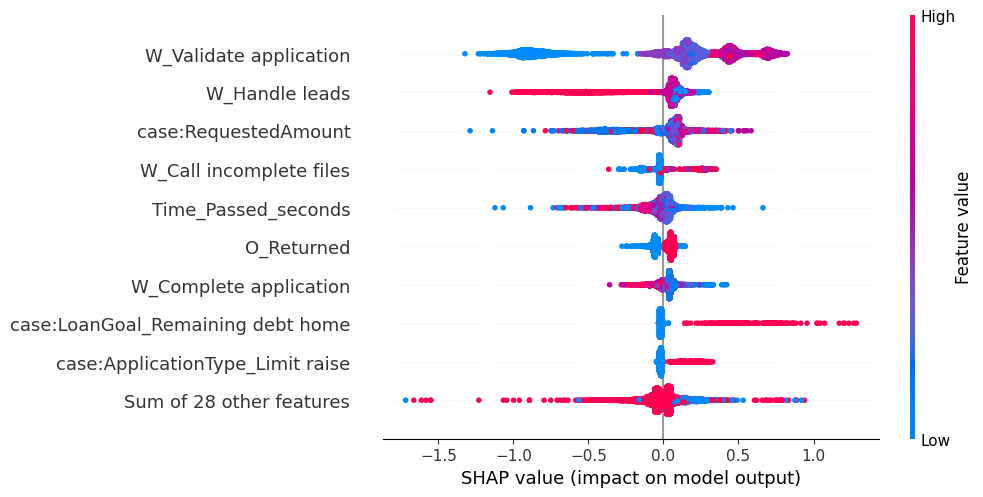

In [161]:
shap.plots.beeswarm(explanation)

In [162]:


# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], df_all_infos.iloc[0,:])



ValueError: ignored

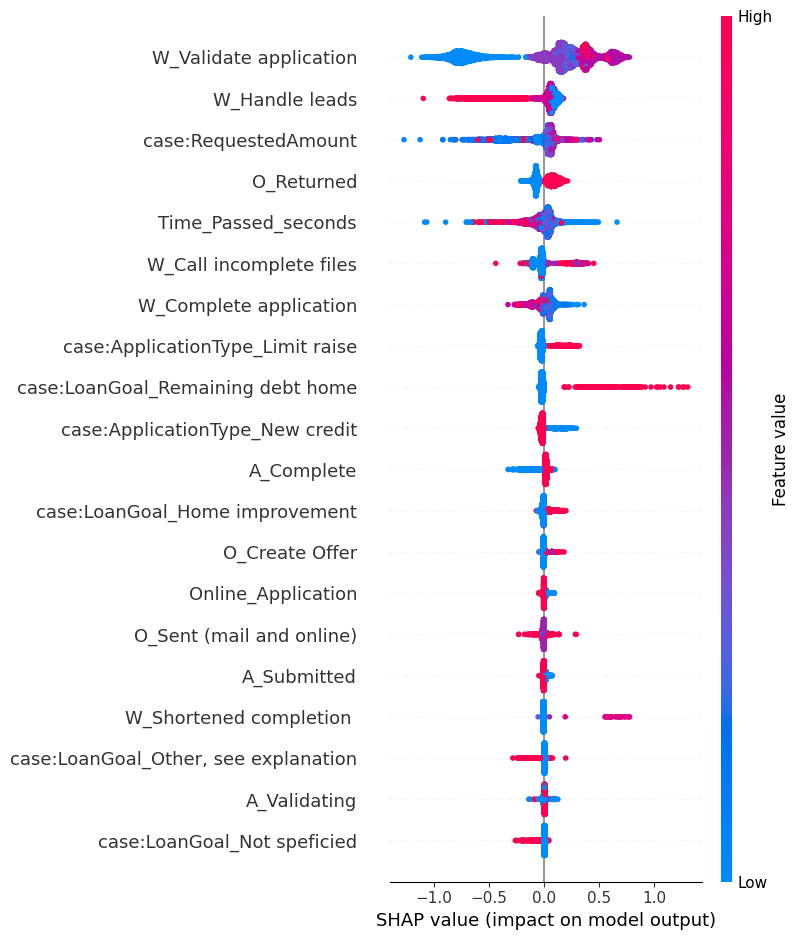

In [165]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.dependence_plot('case:RequestedAmount', shap_values, X_train)

In [ ]:
check = shap.Explanation(shap_values[0])

In [ ]:
shap_values[0]

In [ ]:
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_train)

In [ ]:
shap_values[0]

In [ ]:
shap.plots.waterfall(explanation[0])

Erklärung für einen Datenpunkt !

In [163]:
#shap_values = explainer.shap_values(new_df_data)

shap_values_pred = explainer(new_df_data)


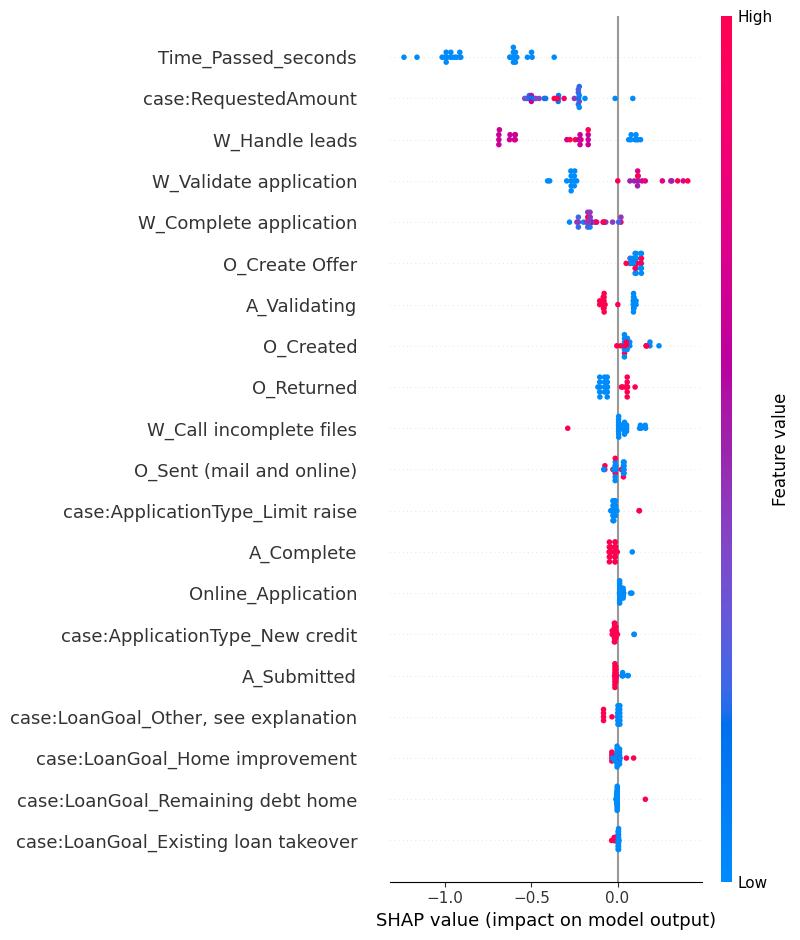

In [164]:
shap.summary_plot(shap_values_pred, new_df_data)


In [ ]:
shap.initjs()


shap.force_plot(explainer.expected_value,
                explanation,
                new_df_data)


In [ ]:
shap_values_pred

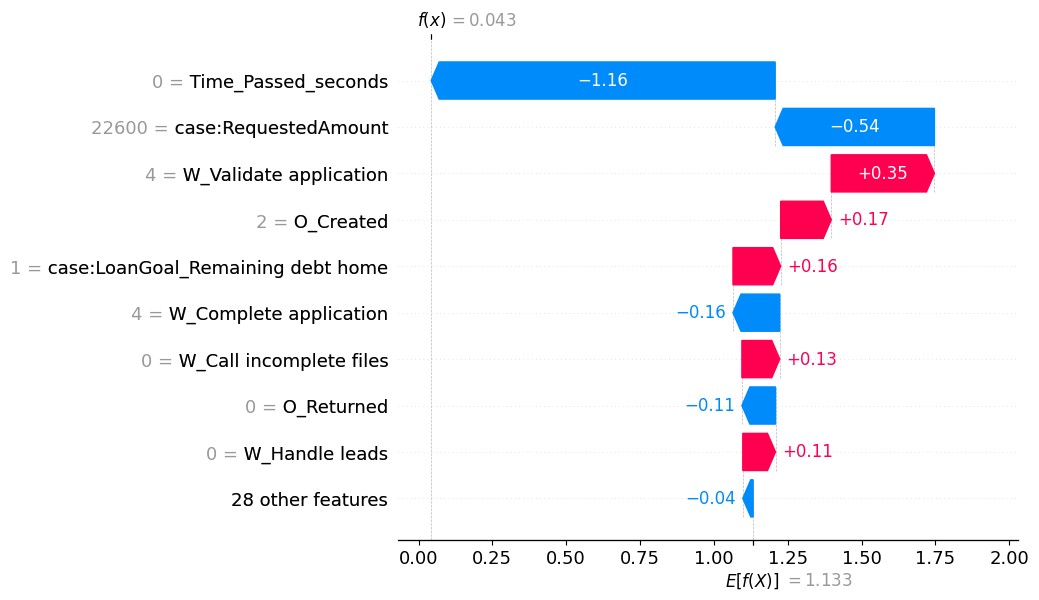

In [168]:
shap.waterfall_plot(shap_values_pred[3])


In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[0], new_df_data)


In [ ]:
shap.plots.beeswarm(explainer.expected_value)


#test verschiedener Bucketing methoden

single bucketing

In [ ]:
log["start"]=pd.to_datetime(log['time:timestamp'])
log['start'] = log.groupby('case:concept:name')['start'].transform('min')
log['Time_Passed'] = log['time:timestamp'] - log['start']
log['Time_Passed_seconds'] = log['Time_Passed'].dt.total_seconds()

In [ ]:
d = {}
i=0
for i in range(21):

#generate log prefixes for all events that end with "A_Pending", last events, after "A_Pending" are deleted
#in the end, keep a df of all traces that end with A_Pending
 if i <=15:
  i += 1
 else:
  from pm4py.objects.log.obj import EventLog, Trace
  # generate prefixes, note that we need to add the casts to EventLog and Trace to make sure that the result is a PM4Py EventLog object
  log_prefixes_Accepted = pm4py.filter_prefixes(log, 'A_Pending', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Denied = pm4py.filter_prefixes(log, 'A_Denied', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')
  log_prefixes_Cancelled = pm4py.filter_prefixes(log, 'A_Cancelled', activity_key='concept:name', timestamp_key='time:timestamp', case_id_key='case:concept:name')

  log_prefixes_Accepted["label"] = "accepted"
  log_prefixes_Cancelled["label"] = "not"
  log_prefixes_Denied["label"] = "not"

  #generate df of log prefixes with length = value in length
  trimmed_log_Accepted = pm4py.get_prefixes_from_log(log_prefixes_Accepted, length=i, case_id_key='case:concept:name')
  trimmed_log_Denied = pm4py.get_prefixes_from_log(log_prefixes_Denied, length=i, case_id_key='case:concept:name')
  trimmed_log_Cancelled = pm4py.get_prefixes_from_log(log_prefixes_Cancelled, length=i, case_id_key='case:concept:name')

  data_labeled_prefixes= pd.concat([trimmed_log_Accepted, trimmed_log_Denied, trimmed_log_Cancelled], axis=0)
  #print(data_labeled_prefixes.head(10))

  id_counts = data_labeled_prefixes['case:concept:name'].value_counts()

  # IDs auswählen, die genau i-mal auftreten
  valid_ids = id_counts[id_counts == i].index

  # DataFrame filtern, um nur die ausgewählten IDs zu behalten
  filtered_df = data_labeled_prefixes[data_labeled_prefixes['case:concept:name'].isin(valid_ids)]
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
  filtered_df['case:concept:name'] = filtered_df['new_id'] #nur wichtig für single Bucketing versuch !
  filtered_df = filtered_df.drop(["new_id","NeueSpalte"],axis=1) #nur wichtig für single Bucketing versuch !
  d['data_labeled_prefixes{0}'.format(i)] = filtered_df



  i+=1

  print(i)




<ipython-input-22-ce4c7016564c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

17


<ipython-input-22-ce4c7016564c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

18


<ipython-input-22-ce4c7016564c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

19


<ipython-input-22-ce4c7016564c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

20


<ipython-input-22-ce4c7016564c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NeueSpalte'] = 'data_labeled_prefixes{0}'.format(i)     #nur wichtig für single Bucketing versuch !
<ipython-input-22-ce4c7016564c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_id'] = filtered_df['NeueSpalte'] + filtered_df['case:concept:name'] #nur wichtig für single Bucketing versuch !


21


<ipython-input-22-ce4c7016564c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['case:concept:name'] = filtered_df['new_id'] #nur wichtig für single Bucketing versuch !


In [ ]:
dataframes_list = list(d.values())

# Alle DataFrames in der Liste zusammenführen
combined_dataframe = pd.concat(dataframes_list)

# Das ursprüngliche Dictionary löschen, wenn Sie es nicht mehr benötigen
del d
del dataframes_list

In [ ]:
def label_first_two_rows(id_group):

    if all(id_group.head(2)['org:resource'] == 'User_1'):
        print(id_group.head(2)['org:resource'])
        return 'Label_1'
    else:
        print(id_group.head(2)['org:resource'])
        return 'Label_2'

# Group the DataFrame by 'ID' and apply the labeling function
labels = combined_dataframe.groupby('case:concept:name').apply(label_first_two_rows)


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
537769    User_1
Name: org:resource, dtype: object
704823    User_51
704824    User_51
Name: org:resource, dtype: object
195279    User_1
195280    User_1
Name: org:resource, dtype: object
381967    User_1
381968    User_1
Name: org:resource, dtype: object
411149    User_1
411150    User_1
Name: org:resource, dtype: object
496522    User_16
496523    User_16
Name: org:resource, dtype: object
833858    User_1
833859    User_1
Name: org:resource, dtype: object
606056    User_1
606057    User_1
Name: org:resource, dtype: object
966987    User_1
966988    User_1
Name: org:resource, dtype: object
401290    User_1
401291    User_1
Name: org:resource, dtype: object
341289    User_49
341290    User_49
Name: org:resource, dtype: object
39360    User_1
39361    User_1
Name: org:resource, dtype: object
31525    User_1
31526    User_1
Name: org:resource, dtype: object
813004    User_1
813005    User_1
Name: org:resource, dtype: obj

In [ ]:
combined_dataframe['Label'] = combined_dataframe['org:resource'].map(labels)


In [ ]:
combined_dataframe = combined_dataframe.merge(labels.rename('New_Data'), left_on='case:concept:name', right_index=True, how='left')


In [ ]:
combined_dataframe["Online_Application"] = combined_dataframe["New_Data"].replace({'Label_1': 1, 'Label_2': 0})


single bucketing encoding

In [ ]:
#das Funktioniert !
#Spalten einfach die dynamic event cat. angeben
spalten = ['concept:name'
           #'org:resource',
           #'EventOrigin'
           ]
ergebnis_df = pd.DataFrame()

# Erstellen Sie eine Pivot-Tabelle für jede Spalte in der Liste
pivot_tables = []
for spalte in spalten:
    pivot_table = pd.pivot_table(combined_dataframe, values='label', index='case:concept:name', columns=spalte, aggfunc='count', fill_value=0, sort=False)
    pivot_tables.append(pivot_table)



In [ ]:
#fügt alle dynamic cat event attributes in ein df.

combined_df = pd.concat([pivot_tables[0], #pivot_tables[1],
                         #pivot_tables[2]
                         ])

df_dynamic_event_cat = combined_df.groupby(combined_df.index, sort=False).agg('first',)



In [ ]:

#static trace cat
work_around = pd.DataFrame()
work_around = combined_dataframe[['case:concept:name',
                               "case:LoanGoal",
                               'case:ApplicationType',
                               'case:RequestedAmount',
                               "label",
                               #"Time_Passed_seconds",
                               "Online_Application"
                               ]]
#work_around['Time_Passed_seconds'] = work_around.groupby('case:concept:name')['Time_Passed_seconds'].transform('max') #umweg um "Time_Passed_seconds" zu verarbeiten

combined_dataframe_time = combined_dataframe.groupby('case:concept:name')['Time_Passed_seconds'].max().reset_index()

# Merge the aggregated dfA_max with dfB based on the 'key' column
work_around = work_around.merge(combined_dataframe_time, on='case:concept:name', how='left')


work_around = work_around.drop_duplicates()
work_around = work_around.set_index("case:concept:name")


In [ ]:
work_around_feature_table = pd.get_dummies(work_around)
#work_around_feature_table

In [ ]:
#Labels extrahieren

list_1 = work_around['label'].tolist()

condition = "accepted"

# Verwenden Sie eine List Comprehension, um die Umwandlung durchzuführen
list_2 = [item == condition for item in list_1]

# Jetzt enthält List2 boolesche Werte
print(list_2)
list_3 = np.asarray(list_2).astype(int)
print(list_3)


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [ ]:
#DF all infos
df_all_infos = pd.concat([df_dynamic_event_cat,work_around_feature_table])

In [ ]:
df_all_infos = df_all_infos.groupby(df_all_infos.index, sort=False).agg('first',)
df_all_infos = df_all_infos.drop(["label_accepted","label_not"],axis=1)
# Ergebnis anzeigen
print((df_all_infos))

##FINALES ENCODEDED DF FÜR ML ALGO !!!!!!!!

                                               A_Create Application  \
case:concept:name                                                     
data_labeled_prefixes16Application_652823628                    1.0   
data_labeled_prefixes16Application_428409768                    1.0   
data_labeled_prefixes16Application_1746793196                   1.0   
data_labeled_prefixes16Application_619403287                    1.0   
data_labeled_prefixes16Application_1529124572                   1.0   
...                                                             ...   
data_labeled_prefixes20Application_1303072211                   1.0   
data_labeled_prefixes20Application_188935499                    1.0   
data_labeled_prefixes20Application_1986755838                   1.0   
data_labeled_prefixes20Application_380535005                    1.0   
data_labeled_prefixes20Application_1722592475                   1.0   

                                               A_Submitted  W_Handle leads  

#Regression

In [ ]:
#!pip install statsmodels
import pandas as pd
import statsmodels.api as sm

selected_columns = ["W_Validate application","label_not"]

df_reg = df_all_infos_labeled[selected_columns]

# Add a constant term to the independent variable
X = df_all_infos_labeled.drop(["label_not"],axis=1)

# Fit the regression model
model = sm.OLS(df_reg['label_not'], X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              label_not   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     82.64
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:50:34   Log-Likelihood:                -11812.
No. Observations:               21368   AIC:                         2.369e+04
Df Residuals:                   21335   BIC:                         2.395e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


#Evaluation noch alter Code, muss angepasst werden

In [ ]:
test_dataloader = DataLoader(data, batch_size=256, shuffle=False)
result, original = evaluate_all(test_dataloader, clf, device)

In [ ]:
pd_pos = pd.DataFrame({'Returns': result[original == 1]})
pd_neg = pd.DataFrame({'Does not return': result[original == 0]})
pd.concat([pd_pos, pd_neg],axis=1).boxplot().set_ylabel('Score')

In [ ]:
# count the unique vectors
dist_bags = np.unique(data_bag, return_counts=True, axis=0)

# sort them with numpy
unique_vectors = dist_bags[0][np.argsort(-dist_bags[1])]
count_vectors = dist_bags[1][np.argsort(-dist_bags[1])]

pd.DataFrame({'Occurrence of unique sample vectors': count_vectors}).boxplot().set_ylabel('Frequency')

In [ ]:
# most frequently used vector
unique_vectors[0]

In [ ]:
# find the sample indicies for this vector
sample_indicies = np.where((data_bag == unique_vectors[0]).all(axis=1))
sample_durations = target_scaled[sample_indicies]

In [ ]:
np.unique(sample_durations, return_counts=True)